In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.pipeline import Pipeline
from scipy.stats import norm, skew, kurtosis
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from xgboost import XGBRegressor
from sklearn.metrics import fbeta_score, make_scorer

import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

In [157]:
# 그래프 그리기 위한 matplolib
%matplotlib inline
plt.style.use('ggplot')
#폰트깨짐방지
mpl.rcParams['axes.unicode_minus']=False

In [158]:
## 트레인 테스트 데이터에서 개장일을 년,월,주,일 단위로 분리해서 데이터 분석하기 위해서 형태변환하여 호출
train = pd.read_csv("train.csv", parse_dates=['Open Date'])
test = pd.read_csv("test.csv",  parse_dates=['Open Date'])

In [159]:
train.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,1999-07-17,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,2008-02-14,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,2013-03-09,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,2012-02-02,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,2009-05-09,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [160]:
test.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,0,2011-01-22,Niğde,Other,FC,1,4.0,4.0,4.0,1,...,2.0,3.0,0,0,0,0,0,0,0,0
1,1,2011-03-18,Konya,Other,IL,3,4.0,4.0,4.0,2,...,1.0,3.0,0,0,0,0,0,0,0,0
2,2,2013-10-30,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,...,2.0,3.0,0,0,0,0,0,0,0,0
3,3,2013-05-06,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,...,2.0,3.0,0,4,0,0,0,0,0,0
4,4,2013-07-31,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,...,5.0,3.0,0,0,0,0,0,0,0,0


Id  : 식당 id. 
Open Date  : 식당 개장일
City :  식당이있는 도시(문자열) 
City Group : 도시 유형. 대도시 또는 기타 두가지 유형(문자) 
Type : 식당의 종류 - FC : 푸드 코트, IL : 인라인, DT : 드라이브 스루, MB : 모바일 4가지형태의 매장
P1, P2-P37 :이 난독 화 된 데이터에는 세 가지 범주가 있습니다. 인구 통계 데이터  는 GIS 시스템이있는 타사 제공 업체에서 수집합니다. 여기에는 특정 지역의 인구, 연령 및 성별 분포, 개발 규모가 포함됩니다. 부동산 데이터는  주로 위치의 m2, 위치의 정면, 주차장 가용성과 관련이 있습니다. 상업 데이터  에는 주로 학교, 은행, 기타 QSR 운영자를 포함하여 관심 지점이 존재합니다.
수익 : 수익 열은 특정 연도의 식당의 (전환 된) 수익을 나타내며 예측 분석의 대상입니다. 값은 실제 달러 값을 의미하지 않도록 변환됩니다. 

In [217]:
train['year']=train['Open Date'].dt.year
train['month']=train['Open Date'].dt.month
train['week']=train['Open Date'].dt.week
train['day']=train['Open Date'].dt.day
train['dayofweek']=train['Open Date'].dt.dayofweek
test['year']=test['Open Date'].dt.year
test['month']=test['Open Date'].dt.month
test['week']=test['Open Date'].dt.week
test['day']=test['Open Date'].dt.day
test['dayofweek']=test['Open Date'].dt.dayofweek

In [218]:
train.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P34,P35,P36,P37,revenue,year,month,week,day,dayofweek
0,0,1999-07-17,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,5,4,3,4,5653753.0,1999,7,28,17,5
1,1,2008-02-14,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,0,0,0,0,6923131.0,2008,2,7,14,3
2,2,2013-03-09,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,0,0,0,0,2055379.0,2013,3,10,9,5
3,3,2012-02-02,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,18,12,12,6,2675511.0,2012,2,5,2,3
4,4,2009-05-09,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3,4,3,3,4316715.0,2009,5,19,9,5


In [219]:
test.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P33,P34,P35,P36,P37,year,month,week,day,dayofweek
0,0,2011-01-22,Niğde,Other,FC,1,4.0,4.0,4.0,1,...,0,0,0,0,0,2011,1,3,22,5
1,1,2011-03-18,Konya,Other,IL,3,4.0,4.0,4.0,2,...,0,0,0,0,0,2011,3,11,18,4
2,2,2013-10-30,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,...,0,0,0,0,0,2013,10,44,30,2
3,3,2013-05-06,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,...,0,0,0,0,0,2013,5,19,6,0
4,4,2013-07-31,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,...,0,0,0,0,0,2013,7,31,31,2


In [220]:
train.columns

Index(['Id', 'Open Date', 'City', 'City Group', 'Type', 'P1', 'P2', 'P3', 'P4',
       'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15',
       'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25',
       'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35',
       'P36', 'P37', 'revenue', 'year', 'month', 'week', 'day', 'dayofweek'],
      dtype='object')

In [221]:
test.columns

Index(['Id', 'Open Date', 'City', 'City Group', 'Type', 'P1', 'P2', 'P3', 'P4',
       'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15',
       'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25',
       'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35',
       'P36', 'P37', 'year', 'month', 'week', 'day', 'dayofweek'],
      dtype='object')

In [222]:
## 결측치 확인
print('=====train=====')
print(train.isnull().sum())
print('=====test=====')
print(test.isnull().sum())

=====train=====
Id            0
Open Date     0
City          0
City Group    0
Type          0
P1            0
P2            0
P3            0
P4            0
P5            0
P6            0
P7            0
P8            0
P9            0
P10           0
P11           0
P12           0
P13           0
P14           0
P15           0
P16           0
P17           0
P18           0
P19           0
P20           0
P21           0
P22           0
P23           0
P24           0
P25           0
P26           0
P27           0
P28           0
P29           0
P30           0
P31           0
P32           0
P33           0
P34           0
P35           0
P36           0
P37           0
revenue       0
year          0
month         0
week          0
day           0
dayofweek     0
dtype: int64
=====test=====
Id            0
Open Date     0
City          0
City Group    0
Type          0
P1            0
P2            0
P3            0
P4            0
P5            0
P6            0
P7          

In [223]:
train.describe()

,Id,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P34,P35,P36,P37,revenue,year,month,week,day,dayofweek
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,...,137.000000,137.000000,137.000000,137.000000,1.370000e+02,137.000000,137.000000,137.000000,137.000000,137.000000
mean,68.000000,4.014599,4.408759,4.317518,4.372263,2.007299,3.357664,5.423358,5.153285,5.445255,...,2.489051,2.029197,2.211679,1.116788,4.453533e+06,2008.678832,7.058394,28.357664,14.671533,2.978102
std,39.692569,2.910391,1.514900,1.032337,1.016462,1.209620,2.134235,2.296809,1.858567,1.834793,...,5.165093,3.436272,4.168211,1.790768,2.576072e+06,4.027359,3.590769,15.685670,8.899859,1.872664
min,0.000000,1.000000,1.000000,0.000000,3.000000,1.000000,1.000000,1.000000,1.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,1.149870e+06,1996.000000,1.000000,1.000000,1.000000,0.000000
25%,34.000000,2.000000,4.000000,4.000000,4.000000,1.000000,2.000000,5.000000,4.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,2.999068e+06,2007.000000,4.000000,14.000000,8.000000,1.000000
50%,68.000000,3.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,5.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,3.939804e+06,2010.000000,8.000000,32.000000,14.000000,3.000000
75%,102.000000,4.000000,5.000000,5.000000,5.000000,2.000000,4.000000,5.000000,5.000000,5.000000,...,3.000000,4.000000,3.000000,2.000000,5.166635e+06,2011.000000,10.000000,41.000000,23.000000,5.000000
max,136.000000,12.000000,7.500000,7.500000,7.500000,8.000000,10.000000,10.000000,10.000000,10.000000,...,24.000000,15.000000,20.000000,8.000000,1.969694e+07,2014.000000,12.000000,52.000000,31.000000,6.000000


In [224]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Id          137 non-null    int64         
 1   Open Date   137 non-null    datetime64[ns]
 2   City        137 non-null    object        
 3   City Group  137 non-null    object        
 4   Type        137 non-null    object        
 5   P1          137 non-null    int64         
 6   P2          137 non-null    float64       
 7   P3          137 non-null    float64       
 8   P4          137 non-null    float64       
 9   P5          137 non-null    int64         
 10  P6          137 non-null    int64         
 11  P7          137 non-null    int64         
 12  P8          137 non-null    int64         
 13  P9          137 non-null    int64         
 14  P10         137 non-null    int64         
 15  P11         137 non-null    int64         
 16  P12         137 non-null  

In [225]:
numerical_features = train.select_dtypes([np.number]).columns.tolist()
categorical_features = train.select_dtypes(exclude = [np.number,np.datetime64]).columns.tolist()

In [226]:
train.select_dtypes([np.number])

,Id,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P34,P35,P36,P37,revenue,year,month,week,day,dayofweek
0,0,4,5.0,4.0,4.0,2,2,5,4,5,...,5,4,3,4,5653753.0,1999,7,28,17,5
1,1,4,5.0,4.0,4.0,1,2,5,5,5,...,0,0,0,0,6923131.0,2008,2,7,14,3
2,2,2,4.0,2.0,5.0,2,3,5,5,5,...,0,0,0,0,2055379.0,2013,3,10,9,5
3,3,6,4.5,6.0,6.0,4,4,10,8,10,...,18,12,12,6,2675511.0,2012,2,5,2,3
4,4,3,4.0,3.0,4.0,2,2,5,5,5,...,3,4,3,3,4316715.0,2009,5,19,9,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,2,3.0,3.0,5.0,4,2,4,4,4,...,0,0,0,0,5787594.0,2008,6,26,25,2
133,133,4,5.0,4.0,4.0,2,3,5,4,4,...,0,0,0,0,9262754.0,2006,10,41,12,3
134,134,3,4.0,4.0,4.0,2,3,5,5,5,...,0,0,0,0,2544857.0,2006,7,27,8,5
135,135,4,5.0,4.0,5.0,2,2,5,5,5,...,0,0,0,0,7217634.0,2010,10,43,29,4


In [227]:
 train.select_dtypes(exclude = [np.number,np.datetime64])

,City,City Group,Type
0,İstanbul,Big Cities,IL
1,Ankara,Big Cities,FC
2,Diyarbakır,Other,IL
3,Tokat,Other,IL
4,Gaziantep,Other,IL
...,...,...,...
132,Trabzon,Other,FC
133,İzmir,Big Cities,FC
134,Kayseri,Other,FC
135,İstanbul,Big Cities,FC


In [228]:
categorical_features

['City', 'City Group', 'Type']

In [229]:
print("train:", train.shape)
print("Test:", test.shape)

train: (137, 48)
Test: (100000, 47)


In [230]:
train['Open Date']

0     1999-07-17
1     2008-02-14
2     2013-03-09
3     2012-02-02
4     2009-05-09
         ...    
132   2008-06-25
133   2006-10-12
134   2006-07-08
135   2010-10-29
136   2009-09-01
Name: Open Date, Length: 137, dtype: datetime64[ns]

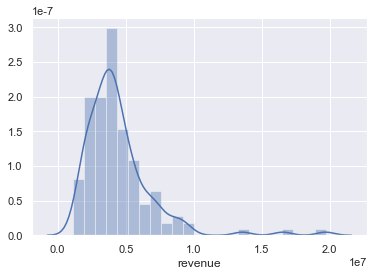

In [231]:
sns.distplot(train['revenue'])

In [232]:
train['City'].value_counts()

İstanbul          50
Ankara            19
İzmir              9
Bursa              5
Samsun             5
Sakarya            4
Antalya            4
Adana              3
Diyarbakır         3
Kayseri            3
Eskişehir          3
Tekirdağ           3
Konya              2
Aydın              2
Muğla              2
Trabzon            2
Balıkesir          1
Tokat              1
Denizli            1
Isparta            1
Kırklareli         1
Şanlıurfa          1
Edirne             1
Kocaeli            1
Elazığ             1
Kastamonu          1
Karabük            1
Amasya             1
Kütahya            1
Afyonkarahisar     1
Bolu               1
Gaziantep          1
Osmaniye           1
Uşak               1
Name: City, dtype: int64

In [233]:
test['City'].value_counts()

İstanbul          34087
Ankara             8720
İzmir              6465
Antalya            5911
Kocaeli            4364
Mersin             2735
Adana              2514
Balıkesir          2463
Bursa              2441
Muğla              1823
Aydın              1617
Tekirdağ           1577
Konya              1576
Gaziantep          1487
Edirne             1230
Manisa             1227
Çanakkale           965
Denizli             964
Diyarbakır          954
Hatay               951
Zonguldak           926
Eskişehir           900
Trabzon             660
Aksaray             650
Bolu                631
Yalova              630
Kırıkkale           622
Malatya             616
Mardin              610
Şanlıurfa           609
Sakarya             604
Batman              604
Rize                345
Artvin              344
Bilecik             339
Afyonkarahisar      331
Nevşehir            328
Sivas               326
Samsun              324
Kayseri             323
Kırşehir            319
Erzincan        

In [234]:
train['City Group'].value_counts()

Big Cities    78
Other         59
Name: City Group, dtype: int64

In [235]:
test['City Group'].value_counts()

Other         50728
Big Cities    49272
Name: City Group, dtype: int64

In [236]:
train['Type'].value_counts()

FC    76
IL    60
DT     1
Name: Type, dtype: int64

In [237]:
test['Type'].value_counts()

FC    57019
IL    40447
DT     2244
MB      290
Name: Type, dtype: int64

In [238]:
train['P1'].value_counts()

2     36
4     35
3     31
12    12
1      9
6      6
9      4
5      4
Name: P1, dtype: int64

In [239]:
test['P1'].value_counts()

4     28295
3     22845
2     22470
5      6862
12     6852
1      5197
6      4092
9      2490
15      897
Name: P1, dtype: int64

In [240]:
train['P2'].value_counts()

5.0    51
4.0    34
3.0    15
7.5    13
2.0    11
1.0     5
6.0     5
4.5     3
Name: P2, dtype: int64

In [241]:
test['P2'].value_counts()

5.0    41260
4.0    19320
3.0    14778
2.0     8719
7.5     8457
6.0     3689
4.5     2274
1.0     1185
1.5      318
Name: P2, dtype: int64

In [242]:
train['Open Date'].head()

0   1999-07-17
1   2008-02-14
2   2013-03-09
3   2012-02-02
4   2009-05-09
Name: Open Date, dtype: datetime64[ns]

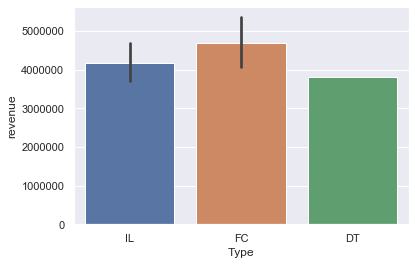

In [243]:
sns.barplot(x='Type', y="revenue", data=train)

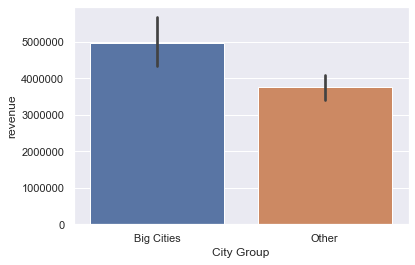

In [244]:
sns.barplot(x="City Group", y="revenue", data=train)

[Text(0, 0.5, 'revenue'), Text(0.5, 1.0, 'Month Revenue')]

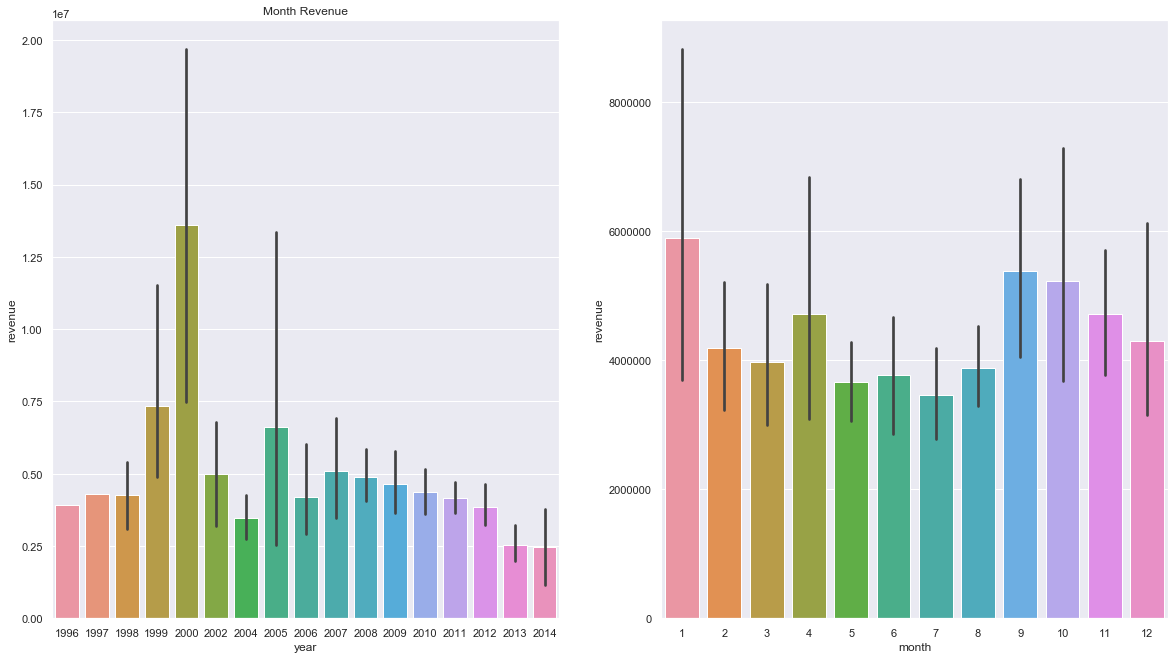

In [245]:
figure, ((ax1,ax2)) = plt.subplots(nrows=1,ncols=2)
figure.set_size_inches(20,11)
sns.barplot(x="year", y="revenue", data=train, ax=ax1)
sns.barplot(x="month", y="revenue", data=train, ax=ax2)
ax1.set(ylabel='revenue', title ='Year Revenue')
ax1.set(ylabel='revenue', title ='Month Revenue')

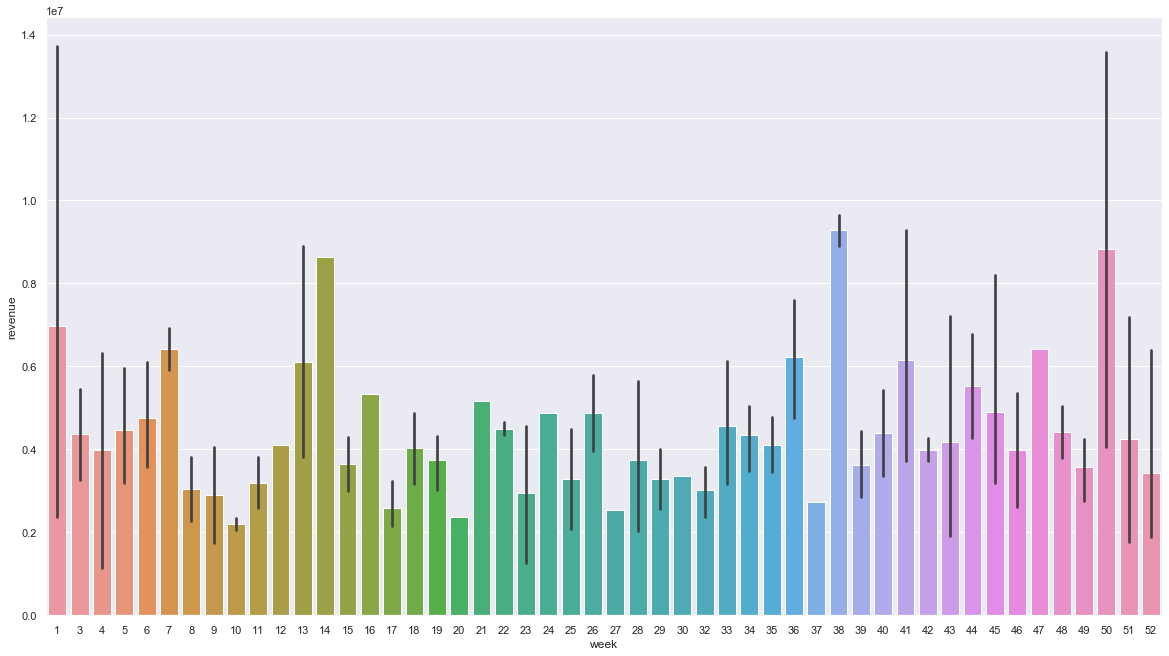

In [246]:
figure, ((ax1)) = plt.subplots(nrows=1,ncols=1)
figure.set_size_inches(20,11)
sns.barplot(x="week", y="revenue", data=train, ax=ax1)

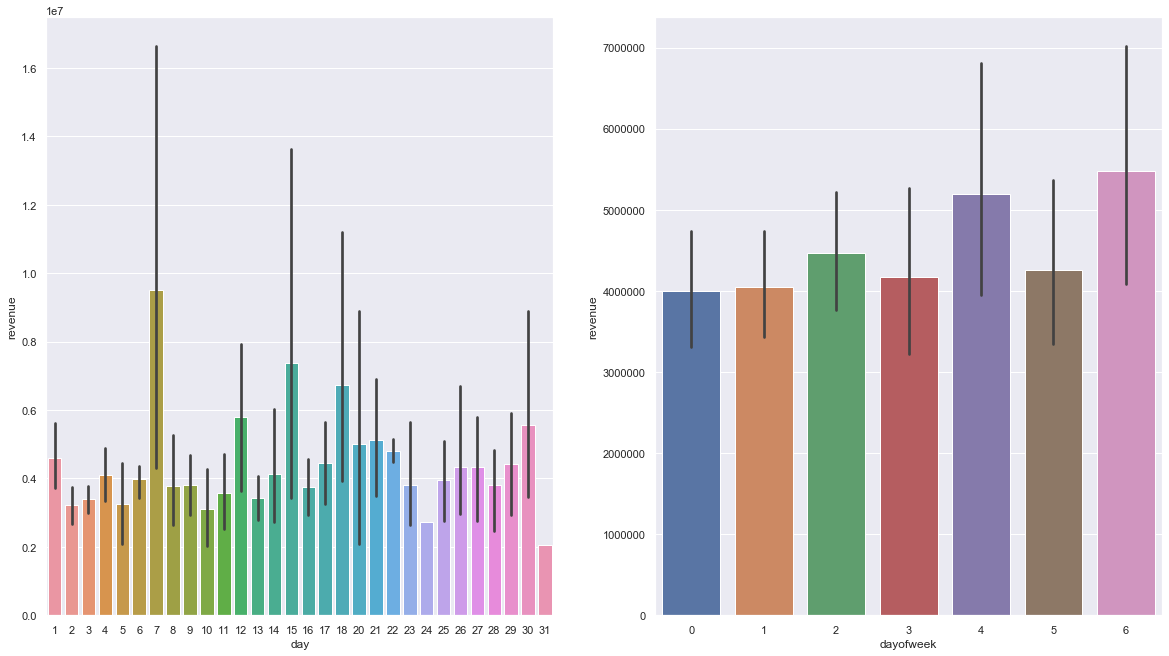

In [248]:
figure, ((ax1,ax2)) = plt.subplots(nrows=1,ncols=2)
figure.set_size_inches(20,11)
sns.barplot(x="day", y="revenue", data=train, ax=ax1)
sns.barplot(x="dayofweek", y="revenue", data=train, ax=ax2)

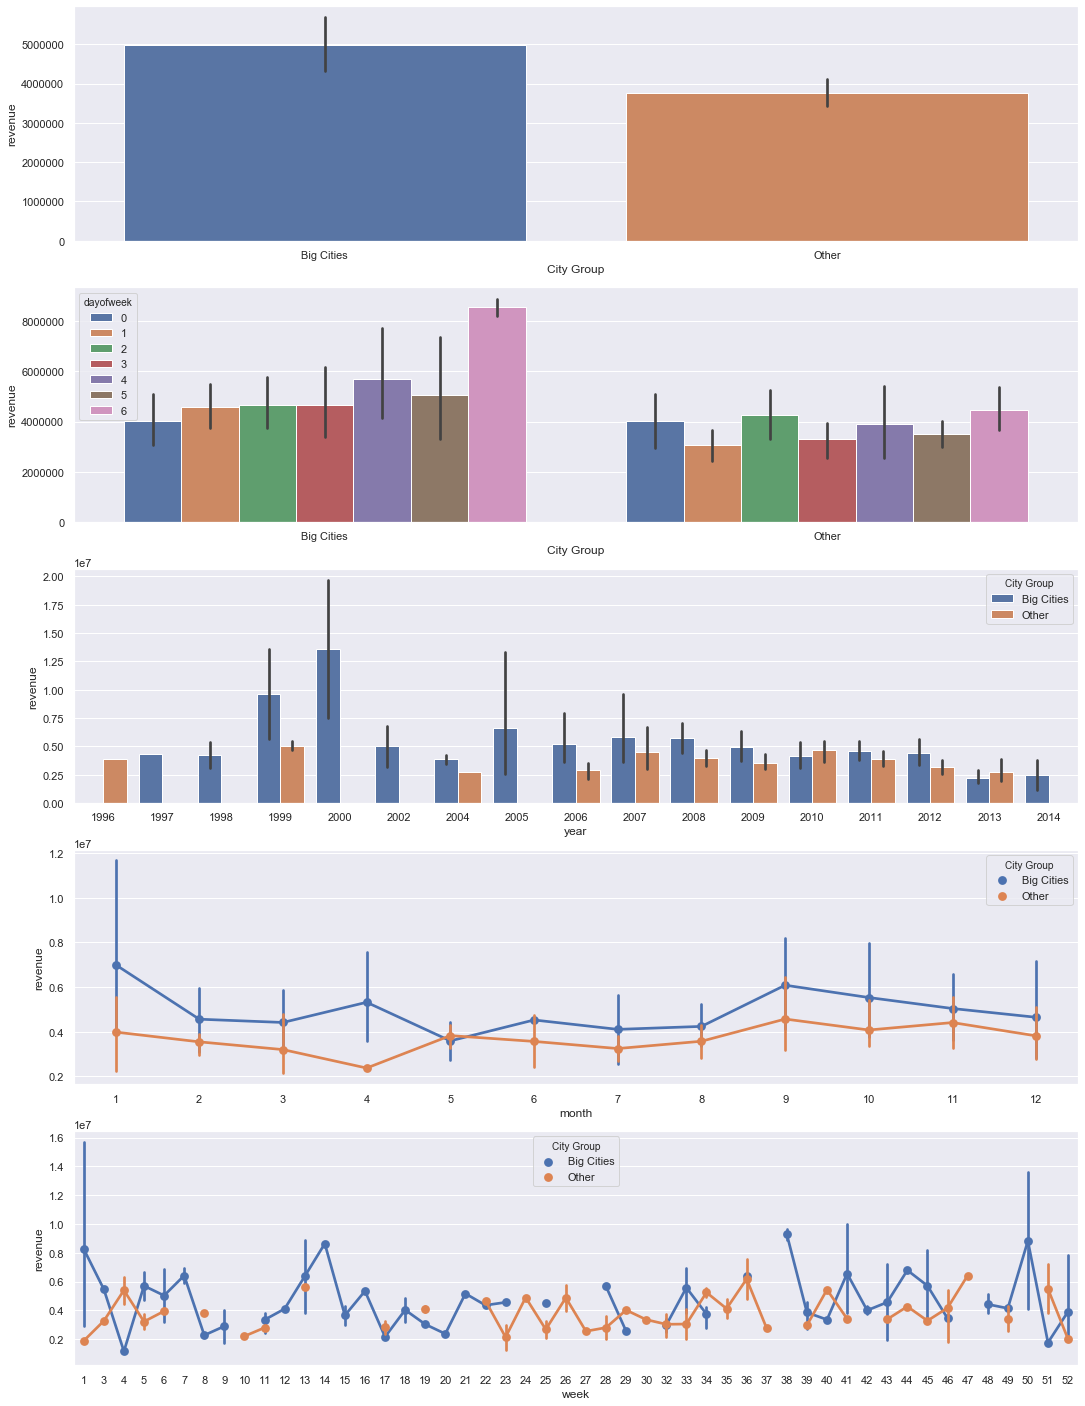

In [275]:
fig,(ax1,ax2,ax3,ax4,ax5)= plt.subplots(nrows=5)
fig.set_size_inches(18,25)

sns.barplot(data=train, x="City Group", y="revenue", ax=ax1)
sns.barplot(data=train, x="City Group", y="revenue", hue="dayofweek", ax=ax2)
sns.barplot(data=train, x="year", y="revenue", hue="City Group", ax=ax3)
sns.pointplot(data=train, x="month", y="revenue", hue="City Group", ax=ax4)
sns.pointplot(data=train, x="week", y="revenue", hue="City Group", ax=ax5)

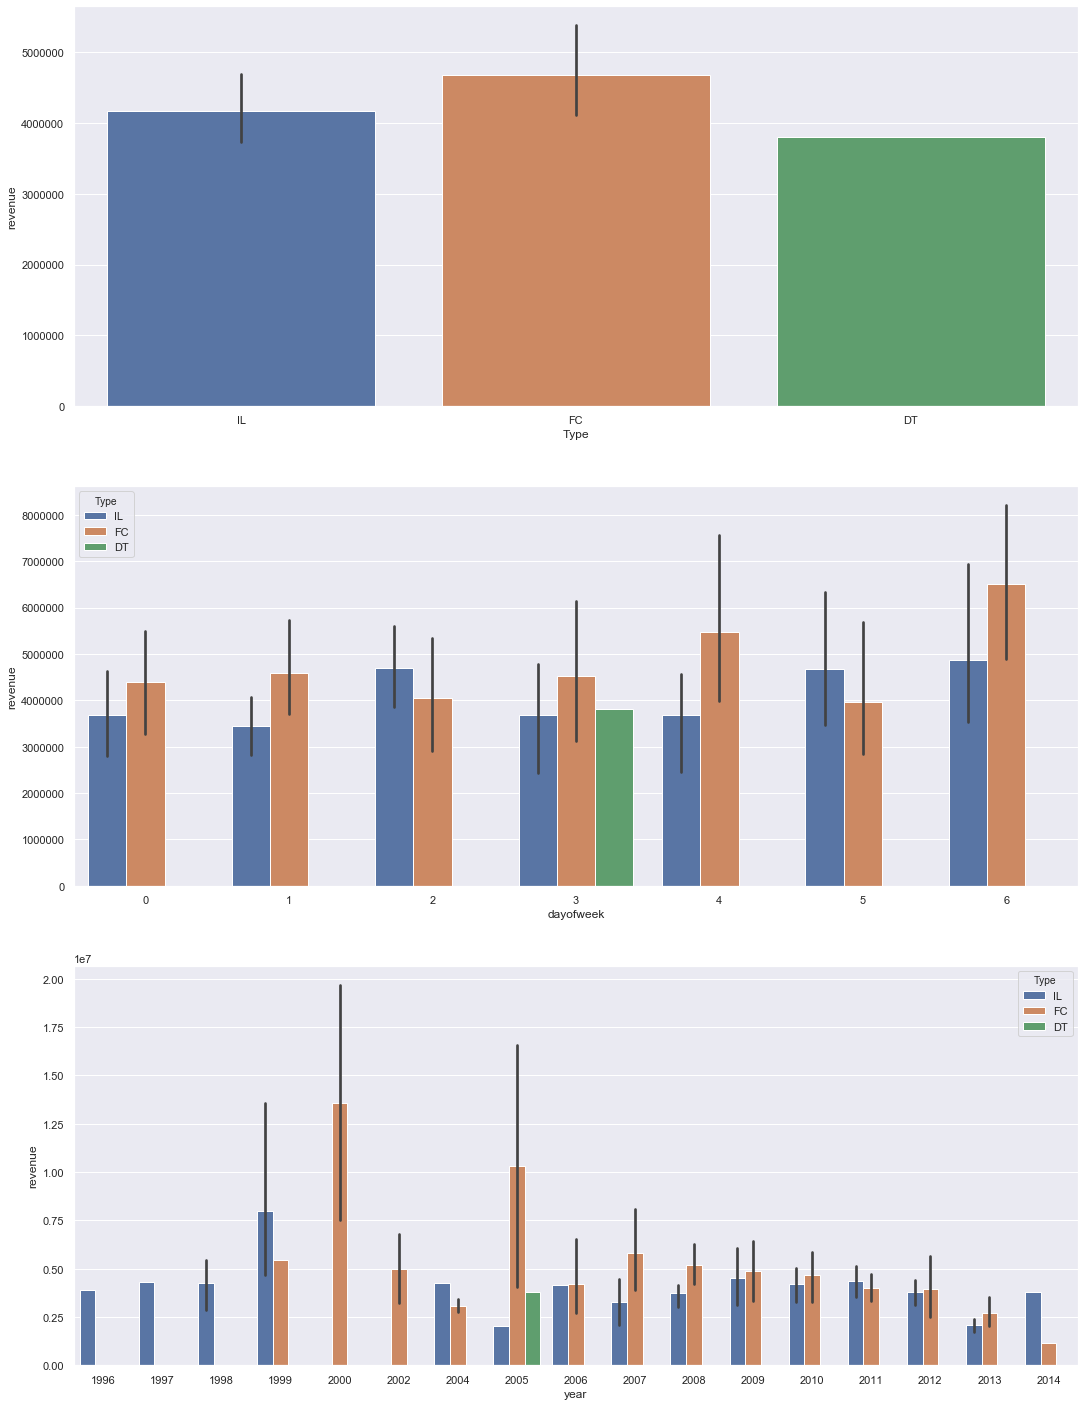

In [280]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3)
fig.set_size_inches(18,25)

sns.barplot(data=train, x="Type", y="revenue", ax=ax1)
sns.barplot(data=train, x="dayofweek", y="revenue", hue="Type", ax=ax2)
sns.barplot(data=train, x="year", y="revenue", hue="Type", ax=ax3)

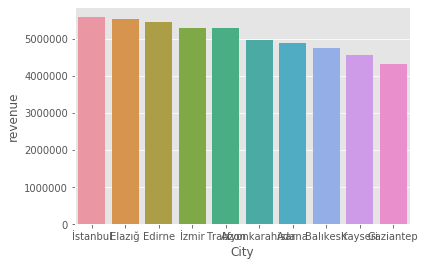

In [99]:
cityPerc = train[["City", "revenue"]].groupby(['City'],as_index=False).mean()

newDF = cityPerc.sort_values(["revenue"],ascending= False)
sns.barplot(x='City', y='revenue', data=newDF.head(10))

In [100]:
train['Open Date'].value_counts()

02/23/2010    2
02/02/2012    2
01/07/2000    2
08/05/2009    1
11/27/2011    1
             ..
04/01/2008    1
05/09/2008    1
10/13/2004    1
08/10/2012    1
07/01/2006    1
Name: Open Date, Length: 134, dtype: int64

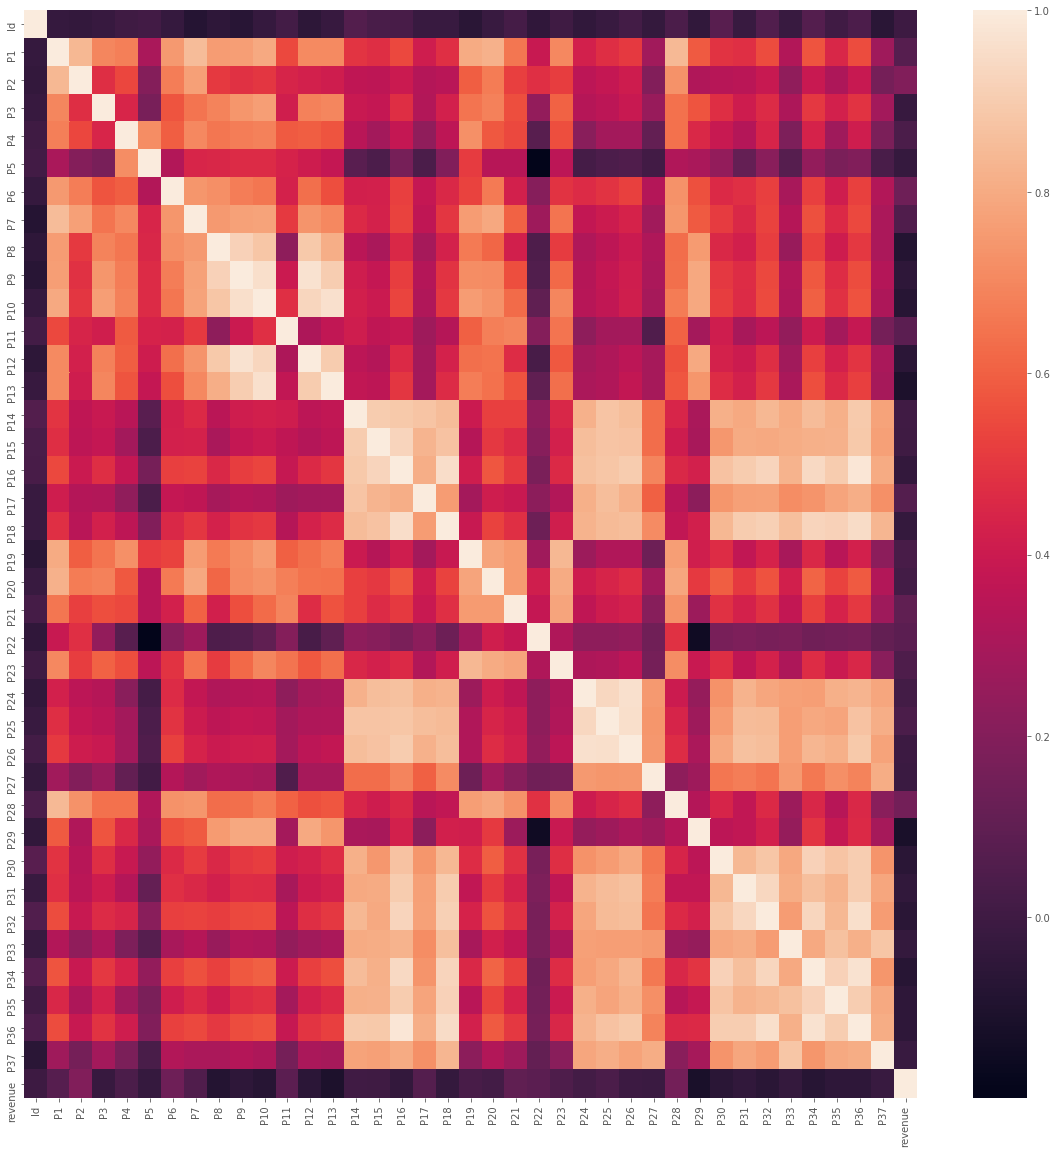

In [101]:
plt.figure(figsize=(20,20))
sns.heatmap(train.corr())

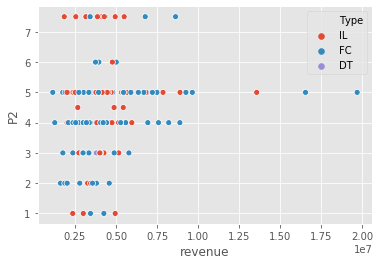

In [102]:
sns.scatterplot(x="revenue", y="P2", hue="Type", data=train)

In [103]:
Y_train = train['revenue']

In [104]:
Y_train.head()

0    5653753.0
1    6923131.0
2    2055379.0
3    2675511.0
4    4316715.0
Name: revenue, dtype: float64

In [105]:
df_feat = train.drop(['revenue'], axis=1)
df_feat = df_feat.drop(['Id'], axis=1)
df_feat = df_feat.drop(['Open Date'], axis=1)
df_feat = df_feat.drop(['City'], axis=1)
df_feat = df_feat.drop(['Type'], axis=1)

In [106]:
df_feat.head()

,City Group,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,Big Cities,4,5.0,4.0,4.0,2,2,5,4,5,...,2.0,3.0,5,3,4,5,5,4,3,4
1,Big Cities,4,5.0,4.0,4.0,1,2,5,5,5,...,3.0,3.0,0,0,0,0,0,0,0,0
2,Other,2,4.0,2.0,5.0,2,3,5,5,5,...,1.0,3.0,0,0,0,0,0,0,0,0
3,Other,6,4.5,6.0,6.0,4,4,10,8,10,...,2.5,7.5,25,12,10,6,18,12,12,6
4,Other,3,4.0,3.0,4.0,2,2,5,5,5,...,1.0,3.0,5,1,3,2,3,4,3,3


In [107]:
df_test = test.drop(['Id'], axis=1)
df_test = df_test.drop(['Open Date'], axis=1)
df_test = df_test.drop(['City'], axis=1)
df_test = df_test.drop(['Type'], axis=1)

In [108]:
df_test.head()

,City Group,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,Other,1,4.0,4.0,4.0,1,2,5,4,5,...,2.0,3.0,0,0,0,0,0,0,0,0
1,Other,3,4.0,4.0,4.0,2,2,5,3,4,...,1.0,3.0,0,0,0,0,0,0,0,0
2,Big Cities,3,4.0,4.0,4.0,2,2,5,4,4,...,2.0,3.0,0,0,0,0,0,0,0,0
3,Other,2,4.0,4.0,4.0,2,3,5,4,5,...,2.0,3.0,0,4,0,0,0,0,0,0
4,Other,2,4.0,4.0,4.0,1,2,5,4,5,...,5.0,3.0,0,0,0,0,0,0,0,0


In [109]:
total = df_feat.isnull().sum().sort_values(ascending=False)
percent = (df_feat.isnull().sum()/df_feat.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
P37,0,0.0
P9,0,0.0
P16,0,0.0
P15,0,0.0
P14,0,0.0
P13,0,0.0
P12,0,0.0
P11,0,0.0
P10,0,0.0
P8,0,0.0


In [110]:
df_feat.columns

Index(['City Group', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9',
       'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19',
       'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29',
       'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37'],
      dtype='object')

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

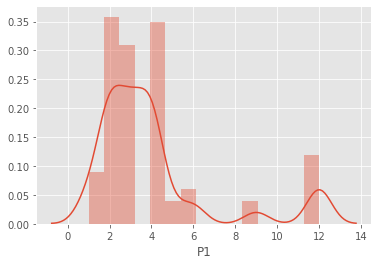

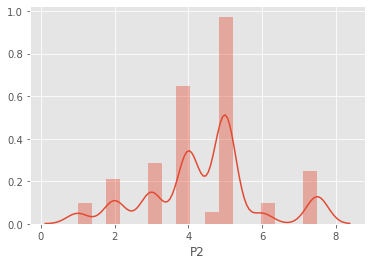

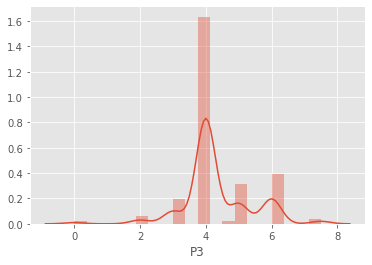

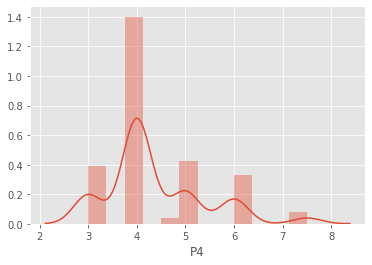

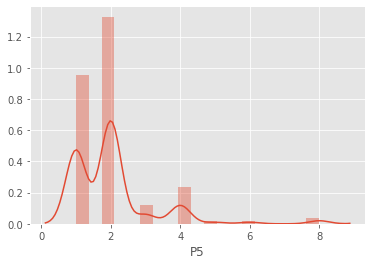

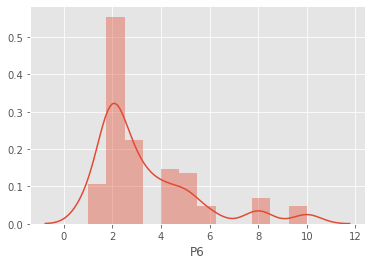

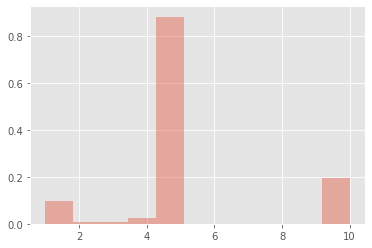

In [113]:
df_pcols = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15',
       'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35',
       'P36', 'P37']
for i, column in enumerate(df_pcols):
    plt.figure()
    sns.distplot(df_feat[column])